In [ ]:
import pandas as pd
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


In [ ]:
text = df_baru['text'].values
label = df_baru[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [ ]:
from sklearn.model_selection import train_test_split
kalimat_latih, kalimat_test, label_latih, label_test = train_test_split(text, label, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=4491, oov_token='x')
tokenizer.fit_on_texts(kalimat_latih) 
tokenizer.fit_on_texts(kalimat_test)
 
sekuens_latih = tokenizer.texts_to_sequences(kalimat_latih)
sekuens_test = tokenizer.texts_to_sequences(kalimat_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

size_of_vocabulary=len(tokenizer.word_index) + 2 #+2 for padding
print(size_of_vocabulary)

29728


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-08-25 07:48:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-25 07:48:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-25 07:48:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# memuat keseluruhan embedding ke dalam memory
import numpy as np
embeddings_index = dict()
f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# buat weight matrix dari kalimat di dalam dokumen training
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=4491,trainable=False),
    tf.keras.layers.LSTM(64, recurrent_dropout=0.2, return_sequences=True,dropout=0.2),
    tf.keras.layers.GlobalMaxPooling1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])

#callbacks
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
checkpoint =ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4491, 300)         8918400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 4491, 64)          93440     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 9,016,325
Trainable params: 97,925
Non-trainable params: 8,918,400
_______________________________________

In [ ]:

history = model.fit(np.array(padded_latih),np.array(label_latih),batch_size=128,epochs=10,
                    validation_data=(np.array(padded_test),np.array(label_test)),
                    verbose=1,callbacks=[early_stop,checkpoint])

Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.4228 - accuracy: 0.4320 WARNING:tensorflow:Model was constructed with shape (None, 4491) for input Tensor("embedding_2_input:0", shape=(None, 4491), dtype=float32), but it was called on an input with incompatible shape (None, 2477).

Epoch 00001: val_accuracy improved from -inf to 0.64494, saving model to best_model.h5
14/14 [==============================] - 365s 26s/step - loss: 1.4228 - accuracy: 0.4320 - val_loss: 1.1675 - val_accuracy: 0.6449
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.9564 - accuracy: 0.7472 
Epoch 00002: val_accuracy improved from 0.64494 to 0.89438, saving model to best_model.h5
14/14 [==============================] - 359s 26s/step - loss: 0.9564 - accuracy: 0.7472 - val_loss: 0.6832 - val_accuracy: 0.8944
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.8348 
Epoch 00003: val_accuracy improved from 0.89438 to 0.90562, saving 

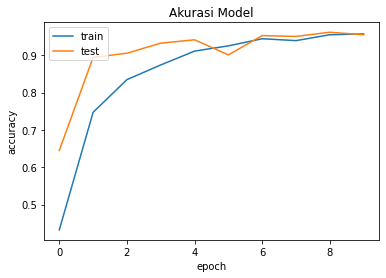

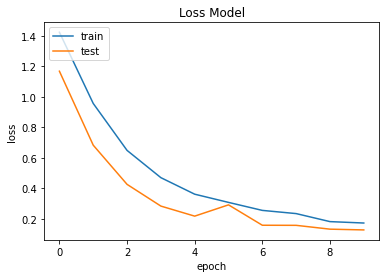

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()